# Analyzing Police Traffic Stops Citations in Austin Texas

Sections:
- Reading and Cleaning
- Analyzing stop citations by race and gender


Data description: Data set used is Racial Profiling Dataset 2015- Citations from Austin's Open Data Portal (https://data.austintexas.gov/Public-Safety/Racial-Profiling-Dataset-2015-Citations/sc6h-qr9f). 
Dataset contains the records of traffic stops citations with variables such as:
    - driver gender (Male, Female)
    - driver race (White, Asian, Black, Hispanic, Middle East, Other)
    - reason for stop
    - was there a search
    - search type
    - what was found during the search
    - among others



## Reading and Cleaning

Start by reading the dataset into a `pandas` DataFrame

In [1]:
import pandas as pd
import numpy as np

# Read 'police.csv' into a DataFrame named austin
austin = pd.read_csv('Racial_Profiling_Dataset_2015-_Citations(Austin_TX).csv')

print('dataframe shape: ',austin.shape)
austin.head()

dataframe shape:  (110847, 11)


,CITATION NUMBER,OFF FROM DATE,OFF TIME,RACE-ORIGIN CODE,CASE PARTY SEX,REASON FOR STOP,RACE KNOWN,VL STREET NAME,MSEARCH Y/N,MSEARCH TYPE,MSEARCH FOUND
0,1111.0,05/25/2015 12:00:00 AM,8:00:00,W,M,1.0,N,10000 BLOCK WEST BEN WHITE BOULEVARD,N,NaN,NaN
1,320540.0,12/07/2015 12:00:00 AM,23:46:00,H,F,1.0,N,SOUTH PLEASANT VALLEY ROAD,N,NaN,NaN
2,1394195.0,09/01/2015 12:00:00 AM,21:05:00,W,M,1.0,N,1300 BLOCK SOUTH 1ST STREET,N,NaN,NaN
3,1395858.0,02/04/2015 12:00:00 AM,20:51:00,W,F,1.0,N,EAST 7TH STREET,N,NaN,NaN
4,1409057.0,12/14/2015 12:00:00 AM,15:57:00,W,M,1.0,N,7200 BLOCK FM 2222 ROAD,N,NaN,NaN


Change the names of the columns to `snake_case` format. Replace integer values with corresponding classes. The classes were taken from Austin's Open Data Portal information about the data set. Also, replace `Y`/`N` with `True`/`False`

In [2]:
# format the names of the columns to 'snake_case'
austin.columns = austin.columns.str.lower()\
                .str.replace(' ','_')\
                .str.replace('-','_')

# change coded values to proper classes
# dictionary with right classes/values for columns
new_vals = {'reason_for_stop':{1:'Violation of transportation code/vehicle laws',
                               2:'Violation of penal code',
                               3:'Consent of interview',
                               4:'Suspicious person',
                               5:'Call for service',
                               6:'Pre-existing knowledge',
                               7:'Specific detail',
                               8:'Other',
                               9:'Violation of city ordinance',
                               10:'Outstanding warran'},
            'msearch_type':{1:'frisk for safety',
                            2:'consent',
                            3:'probable cause',
                            4:'contraband/evidence in plain view',
                            5:'towing of motor vehicle',
                            6:'arrest of person in vehicle'},
            'msearch_found':{1:'weapons',
                             2:'cash',
                             3:'alcohol',
                             4:'other',
                             5:'nothing',
                             6:'drugs'},
            'race_known':{'Y':True,
                          'N':False},
            'msearch_y/n':{'Y':True,
                           'N':False},
            'race_origin_code':{'N':'O'}
           }

# change classes 'austin' dataframe
austin.replace(new_vals,inplace=True)

austin.head()

,citation_number,off_from_date,off_time,race_origin_code,case_party_sex,reason_for_stop,race_known,vl_street_name,msearch_y/n,msearch_type,msearch_found
0,1111.0,05/25/2015 12:00:00 AM,8:00:00,W,M,Violation of transportation code/vehicle laws,False,10000 BLOCK WEST BEN WHITE BOULEVARD,False,NaN,NaN
1,320540.0,12/07/2015 12:00:00 AM,23:46:00,H,F,Violation of transportation code/vehicle laws,False,SOUTH PLEASANT VALLEY ROAD,False,NaN,NaN
2,1394195.0,09/01/2015 12:00:00 AM,21:05:00,W,M,Violation of transportation code/vehicle laws,False,1300 BLOCK SOUTH 1ST STREET,False,NaN,NaN
3,1395858.0,02/04/2015 12:00:00 AM,20:51:00,W,F,Violation of transportation code/vehicle laws,False,EAST 7TH STREET,False,NaN,NaN
4,1409057.0,12/14/2015 12:00:00 AM,15:57:00,W,M,Violation of transportation code/vehicle laws,False,7200 BLOCK FM 2222 ROAD,False,NaN,NaN


This analysis would focus on the activity by race and gender, so only records with information about driver race and gender are going to be considered. records with null values for column `'race_origin_code'` and `'case_party_sex'` are dropped from the dataset.

In [3]:
# Drop all rows that are missing 'driver_gender'
austin.dropna(subset=['race_origin_code','case_party_sex'],
              inplace=True)

print('dataframe shape: ',austin.shape)

dataframe shape:  (109760, 11)


Check current data types and change to more adequate ones. 

In [4]:
# Checking data types
austin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109760 entries, 0 to 110846
Data columns (total 11 columns):
citation_number     109102 non-null float64
off_from_date       109760 non-null object
off_time            109760 non-null object
race_origin_code    109760 non-null object
case_party_sex      109760 non-null object
reason_for_stop     108351 non-null object
race_known          109760 non-null bool
vl_street_name      109710 non-null object
msearch_y/n         109760 non-null bool
msearch_type        2179 non-null object
msearch_found       2179 non-null object
dtypes: bool(2), float64(1), object(8)
memory usage: 8.6+ MB


Data types changes: concatenate columns`'off_from_date'` and `'off_time'` into `'off_datetime'`, set type to `date` and set as index. For `'case_party_sex'`, `'race_origin_code'`, `'reason_for_stop'`, `'msearch_type'`, and `'msearch_found'` change to `categorical`.

In [5]:
# concatenate date and time columns
austin['off_datetime'] = austin['off_from_date'].str[:10]\
                        .str.cat(austin.off_time,sep=' ')

# change 'off_datetime' to date
austin['off_datetime'] = pd.to_datetime(austin.off_datetime)

# drop 'off_from_date' and 'off_time' columns
austin.drop(['off_time','off_from_date'],
            axis=1,
            inplace=True)

# set 'stop_datetime' as the index
austin.set_index('off_datetime',inplace=True)

# change to categorical variables
categoricals = ['race_origin_code',
                'case_party_sex',
                'reason_for_stop',
                'msearch_type',
                'msearch_found']

for col in categoricals:
    austin[col] = austin[col].astype('category')

    
austin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109760 entries, 2015-05-25 08:00:00 to 2015-12-14 06:11:00
Data columns (total 9 columns):
citation_number     109102 non-null float64
race_origin_code    109760 non-null category
case_party_sex      109760 non-null category
reason_for_stop     108351 non-null category
race_known          109760 non-null bool
vl_street_name      109710 non-null object
msearch_y/n         109760 non-null bool
msearch_type        2179 non-null category
msearch_found       2179 non-null category
dtypes: bool(2), category(5), float64(1), object(1)
memory usage: 3.2+ MB


Save clean data set to a new csv file named `clean_austin_police.csv`.

In [6]:
# Save DataFrame to csv files
austin.to_csv('clean_austin_police.csv')

# show first five rows
austin.head()

,citation_number,race_origin_code,case_party_sex,reason_for_stop,race_known,vl_street_name,msearch_y/n,msearch_type,msearch_found
off_datetime,,,,,,,,,
2015-05-25 08:00:00,1111.0,W,M,Violation of transportation code/vehicle laws,False,10000 BLOCK WEST BEN WHITE BOULEVARD,False,NaN,NaN
2015-12-07 23:46:00,320540.0,H,F,Violation of transportation code/vehicle laws,False,SOUTH PLEASANT VALLEY ROAD,False,NaN,NaN
2015-09-01 21:05:00,1394195.0,W,M,Violation of transportation code/vehicle laws,False,1300 BLOCK SOUTH 1ST STREET,False,NaN,NaN
2015-02-04 20:51:00,1395858.0,W,F,Violation of transportation code/vehicle laws,False,EAST 7TH STREET,False,NaN,NaN
2015-12-14 15:57:00,1409057.0,W,M,Violation of transportation code/vehicle laws,False,7200 BLOCK FM 2222 ROAD,False,NaN,NaN


## Analyzing citations by race and gender

Next code cell creates two dataframes, first one with the proportion of each reason for stop by race, eg. the proportion of 'violation of transportation code/vehicle laws' when the driver race was 'Asian' is 0.8931. Second with the proportion of each reason for stop by gender.

The first dataframe starts by grouping the `austin` dataframe by `'race_origin_code'` then selects the Series `'reason_for_stop'` and calculates the proportion of each reason by race using the `.value_counts` method (without `normalize=True` it returns the actual values, not proportions). Then it converts the series to a dataframe and reset the index to pass `'race_origin_code'` and `'reason_for_stop'` to columns instead of indices. The second dataframe uses the same methods only substituting `'race_origin_code'` with `'case_party_sex'`

In [7]:
# create dataframe with proportions of reasons for stop
reasons_proportions_race = austin.groupby('race_origin_code')\
                            .reason_for_stop\
                            .value_counts(normalize=True)\
                            .to_frame(name='proportion_by_race')\
                            .reset_index()

# create dataframe with proportions of reasons for stop
reasons_proportions_gender = austin.groupby('case_party_sex')\
                            .reason_for_stop\
                            .value_counts(normalize=True)\
                            .to_frame(name='proportion_by_gender')\
                            .reset_index()

# show first five rows of proportions by race
reasons_proportions_race.head()

,race_origin_code,reason_for_stop,proportion_by_race
0,A,Violation of transportation code/vehicle laws,0.893101
1,A,Call for service,0.087799
2,A,Violation of city ordinance,0.007412
3,A,Violation of penal code,0.006271
4,A,Other,0.004276


Create bar charts to visually see the proportions of reasons for stop by race and gender

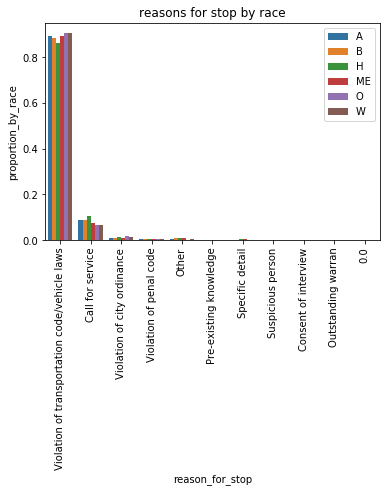

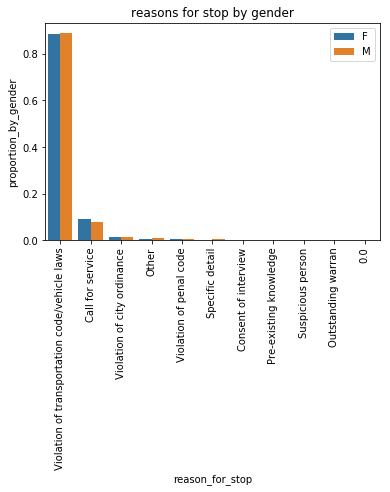

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot proportions by race
sns.barplot(x='reason_for_stop',
            y='proportion_by_race',
            hue='race_origin_code',
            data=reasons_proportions_race)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('reasons for stop by race')
plt.show()

# plot proportions by gender
sns.barplot(x='reason_for_stop',
            y='proportion_by_gender',
            hue='case_party_sex',
            data=reasons_proportions_gender)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title('reasons for stop by gender')
plt.show()

It doesn't seem to be much difference in the reasons for stop when looking them by race and by gender. Most seem to be violations of transportation code\vehicle laws.

### Now looking at proportions of searches being conducted by race and by gender

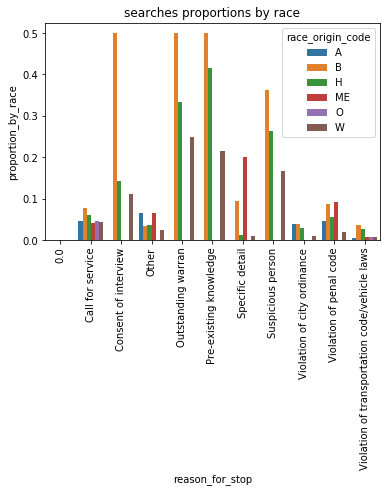

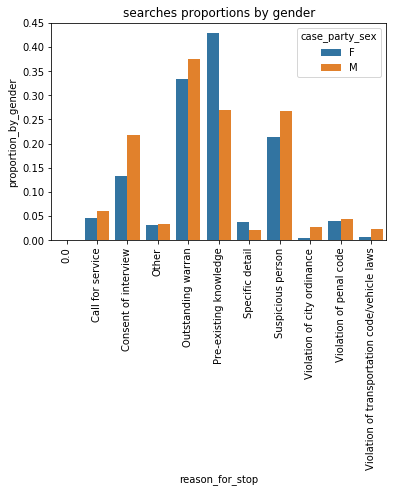

In [10]:
# proportions of searches by race
search_proportions_race = austin.groupby(['race_origin_code','reason_for_stop'])\
                            ['msearch_y/n']\
                            .mean()\
                            .to_frame(name='proportion_by_race')\
                            .reset_index()

# proportions of searches by gender
search_proportions_gender = austin.groupby(['case_party_sex','reason_for_stop'])\
                            ['msearch_y/n']\
                            .mean()\
                            .to_frame(name='proportion_by_gender')\
                            .reset_index()

# creating bar plot for searches by race
sns.barplot(x="reason_for_stop",
            y="proportion_by_race",
            hue="race_origin_code",
            data=search_proportions_race)
plt.xticks(rotation=90)
plt.title('searches proportions by race')
plt.show()

# creating bar plot for searches by gender
sns.barplot(x="reason_for_stop",
            y="proportion_by_gender",
            hue="case_party_sex",
            data=search_proportions_gender)
plt.xticks(rotation=90)
plt.title('searches proportions by gender')
plt.show()

When looking at searches conducted by race it seems that when the reasons are consent of interview, outstanding warran, pre-existing knowledge, and suspicious person both hispanic and black have higher proportions of being searched. 

A further and more extense analysis should be performed to find the causes for this behaviors, the data analyzed here in no way would show a reason of why this occured. It merely shows that for this period of time (2015) from the persons stopped in traffic the proportion of hispanic and blacks searched where higher.

When there is pre-existing knowledge females seem to be searched in higher proportions. However, as explained in the paragraph above, further and more extense analysis should be done to finde the cause for this.

### Now looking at the data when `'frisk'` was a reason to search.

first a `bool` type column needs to be created with values `True` when a search was conducted where a reason was `'frisk'`.

Then calculate the proportion of searches made for frisk. For this, first only the records that had a search need to be selected, if not then the propoton will be of the total traffic stops, not of the searches.

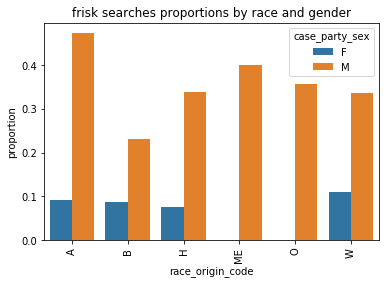

In [11]:
# create column 'frisk'
austin['frisk'] = austin.replace({'msearch_type':{np.nan:'no search'}})\
                .msearch_type\
                .str\
                .contains('frisk for safety', na=False)\
                .astype('bool')

# selecting only records with searches
searched = austin[austin['msearch_y/n'] == True]

# calculate proportion of frisk searches
frisk_proportions = searched.groupby(['race_origin_code','case_party_sex'])\
                    .frisk\
                    .mean()\
                    .to_frame(name='proportion')\
                    .reset_index()

# creating bar plot for searches by race
sns.barplot(x="race_origin_code",
            y="proportion",
            hue="case_party_sex",
            data=frisk_proportions)
plt.xticks(rotation=90)
plt.title('frisk searches proportions by race and gender')
plt.show()


Looking at the data of searches where frisk is the reason doesn't show the same results as searches in general. In this case hispanics and blacks are not searched in higher proportions than other races.

Frisk seem to be a search reason when stopping male drivers. However, a more extense analysis should be conducted to find the causes for this, as it can't be explained by this data set.

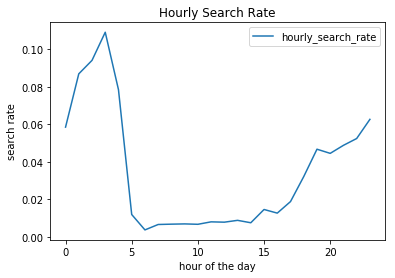

In [12]:
# calculate the hourly searches and create dataframe
hourly_search_rate = austin.groupby(austin.index.hour)\
                    ['msearch_y/n']\
                    .mean()\
                    .to_frame('hourly_search_rate')

# plot hourly_search_rate
hourly_search_rate.plot()
plt.title('Hourly Search Rate')
plt.xlabel('hour of the day')
plt.ylabel('search rate')
plt.show()

From around 18:00 to 4:00 the search rate increases. Meaning that someone stopped during these hours is more likely to get searched.

A hypothesis could be that police officers feel more threatened at this time of the day. So looking at `'frisk for safety'` as reason to search could give an insight about this.

Looking at the search rates and frisk reason to search by hours of the day

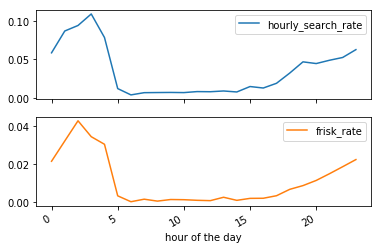

In [13]:
frisk_rate = austin.groupby(austin.index.hour)\
                    .frisk\
                    .mean()\
                    .to_frame('frisk_rate')

# concatenate hourle_search_rate and frisk_rate
frisk_search_rate = pd.concat([hourly_search_rate,frisk_rate],
                              axis=1)

# plot hourly_search_rate
frisk_search_rate.plot(subplots=True)
plt.xlabel('hour of the day')
plt.show()

It looks like the hypothesis could be right, then again further analysis should be conducted to verify this.